Credit Risk Modelling (using german_cred_data)



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown, Latex

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from collections import Counter
import plotly.figure_factory as ff
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, silhouette_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score
# to split the data
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report, fbeta_score
#To evaluate our model
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn import model_selection
# Algorithmns models to be compared
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

In [3]:
pip install kaggle

In [4]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download kabure/german-credit-data-with-risk

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/kabure/german-credit-data-with-risk
License(s): CC0-1.0
  0% 0.00/11.2k [00:00<?, ?B/s]
100% 11.2k/11.2k [00:00<00:00, 13.8MB/s]


In [5]:
df = pd.read_csv("german-credit-data-with-risk.zip", index_col=False)
df.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad


In [6]:
df.drop(columns=['Unnamed: 0'], inplace=True)

In [7]:
df.info()
print(df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 78.2+ KB
(1000, 10)


In [8]:
df.describe(include = 'all')

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
count,1000.000000,1000,1000.000000,1000,817,606,1000.000000,1000.000000,1000,1000
unique,NaN,2,NaN,3,4,3,NaN,NaN,8,2
top,NaN,male,NaN,own,little,little,NaN,NaN,car,good
freq,NaN,690,NaN,713,603,274,NaN,NaN,337,700
mean,35.546000,NaN,1.904000,NaN,NaN,NaN,3271.258000,20.903000,NaN,NaN
std,11.375469,NaN,0.653614,NaN,NaN,NaN,2822.736876,12.058814,NaN,NaN
min,19.000000,NaN,0.000000,NaN,NaN,NaN,250.000000,4.000000,NaN,NaN
25%,27.000000,NaN,2.000000,NaN,NaN,NaN,1365.500000,12.000000,NaN,NaN
50%,33.000000,NaN,2.000000,NaN,NaN,NaN,2319.500000,18.000000,NaN,NaN
75%,42.000000,NaN,2.000000,NaN,NaN,NaN,3972.250000,24.000000,NaN,NaN


In [9]:
print(df.nunique()) #print non-unique values in each column

Age                  53
Sex                   2
Job                   4
Housing               3
Saving accounts       4
Checking account      3
Credit amount       921
Duration             33
Purpose               8
Risk                  2
dtype: int64


In [10]:
concat_cols = [col for col in df.columns if df[col].dtypes == 'O']

for col in concat_cols:
    print(df[col].value_counts(), "\n\n")

Sex
male      690
female    310
Name: count, dtype: int64 


Housing
own     713
rent    179
free    108
Name: count, dtype: int64 


Saving accounts
little        603
moderate      103
quite rich     63
rich           48
Name: count, dtype: int64 


Checking account
little      274
moderate    269
rich         63
Name: count, dtype: int64 


Purpose
car                    337
radio/TV               280
furniture/equipment    181
business                97
education               59
repairs                 22
domestic appliances     12
vacation/others         12
Name: count, dtype: int64 


Risk
good    700
bad     300
Name: count, dtype: int64 




In [11]:
df.isnull().sum()

,0
Age,0
Sex,0
Job,0
Housing,0
Saving accounts,183
Checking account,394
Credit amount,0
Duration,0
Purpose,0
Risk,0


In [12]:
# get a list of columns that have more than 80% null values
na_values = df.isnull().mean()
na_values
# na_values[na_values>0.8] uncomment this line to get the main result

,0
Age,0.000
Sex,0.000
Job,0.000
Housing,0.000
Saving accounts,0.183
Checking account,0.394
Credit amount,0.000
Duration,0.000
Purpose,0.000
Risk,0.000


In [13]:
#plotting the target or the dependent variable(Risk)
trace0 = go.Bar(
            x = df[df["Risk"]== 'good']["Risk"].value_counts().index.values,
            y = df[df["Risk"]== 'good']["Risk"].value_counts().values,
            name='Good credit'
    )

trace1 = go.Bar(
            x = df[df["Risk"]== 'bad']["Risk"].value_counts().index.values,
            y = df[df["Risk"]== 'bad']["Risk"].value_counts().values,
            name='Bad credit'
    )

data = [trace0, trace1]

layout = go.Layout(

)

layout = go.Layout(
    width = 600,
    height = 500,
    yaxis=dict(
        title='Count'
    ),
    xaxis=dict(
        title='Risk Variable'
    ),
    title='Target variable distribution'
)

fig = go.Figure(data=data, layout=layout)

fig.show(renderer = "colab")

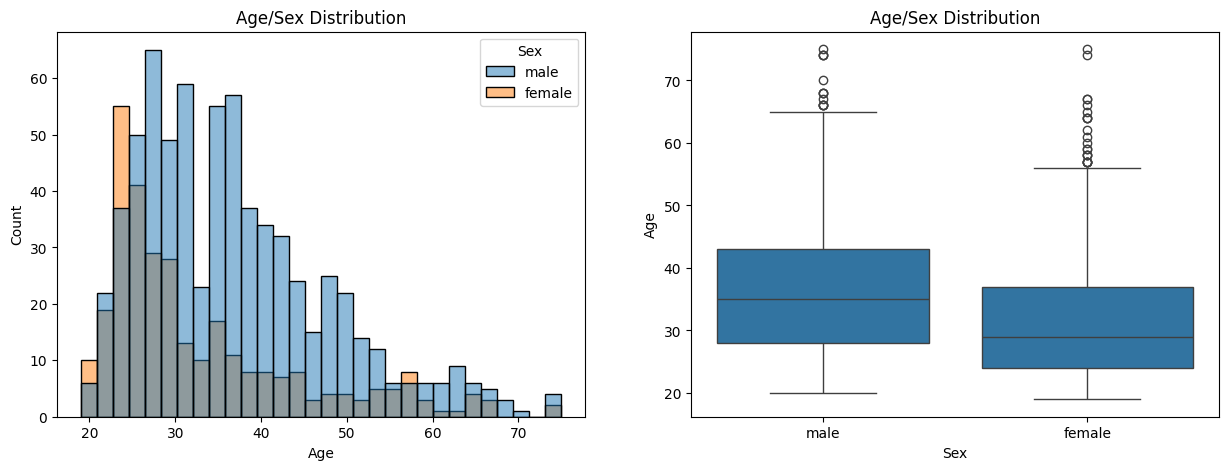

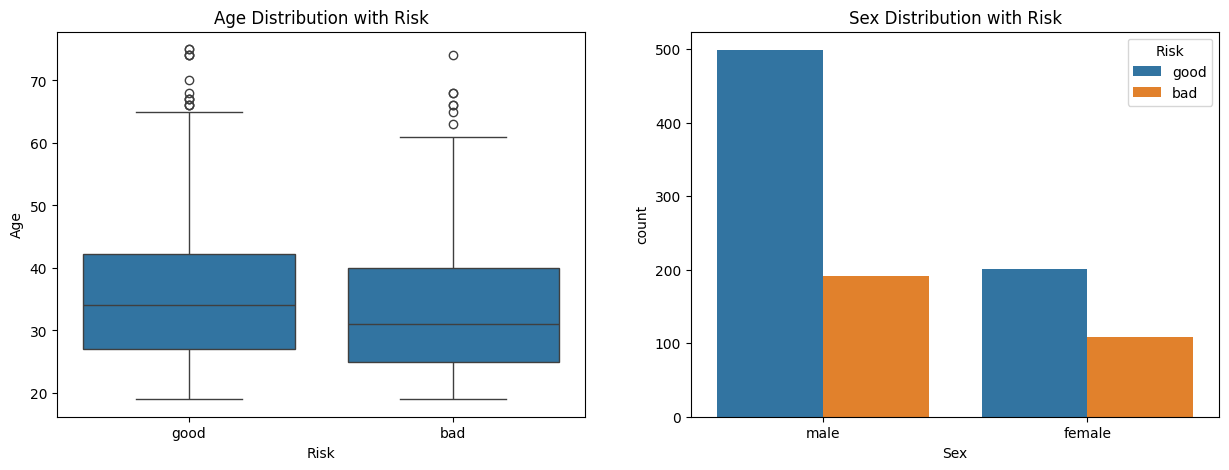

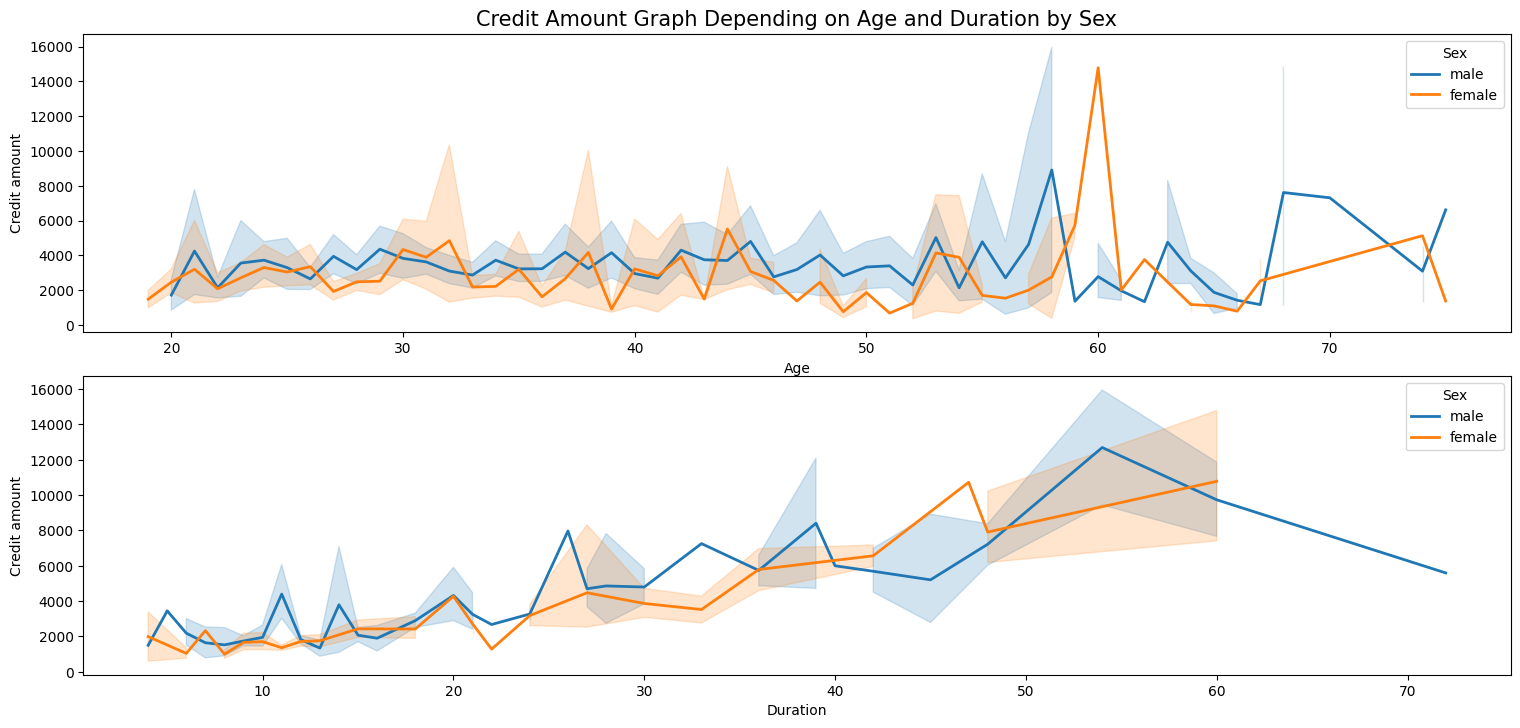

In [14]:
# age sex distribution ; age wise risk ; sex wise risk
fig, ax = plt.subplots(1,2,figsize=(15,5))
sns.histplot(df, x='Age', bins=30, hue="Sex", ax=ax[0]).set_title("Age/Sex Distribution");
sns.boxplot(data=df, x="Sex", y="Age", ax=ax[1]).set_title("Age/Sex Distribution");

fig, ax = plt.subplots(1,2,figsize=(15,5))
sns.boxplot(data=df, x='Risk', y='Age', ax=ax[0]).set_title("Age Distribution with Risk");
sns.countplot(data=df, x="Sex", hue="Risk", ax=ax[1]).set_title("Sex Distribution with Risk");

fig, ax = plt.subplots(2,1,figsize=(15,7))
plt.tight_layout()
sns.lineplot(data=df, x='Age', y='Credit amount', hue='Sex', lw=2, ax=ax[0]).set_title("Credit Amount Graph Depending on Age and Duration by Sex", fontsize=15);
sns.lineplot(data=df, x='Duration', y='Credit amount', hue='Sex', lw=2, ax=ax[1]);

In [15]:
df_good = df.loc[df["Risk"] == 'good']['Age'].values.tolist()
df_bad = df.loc[df["Risk"] == 'bad']['Age'].values.tolist()
df_age = df['Age'].values.tolist()

#First plot
trace0 = go.Histogram(
    x=df_good,
    histnorm='probability',
    name="Good Credit"
)
#Second plot
trace1 = go.Histogram(
    x=df_bad,
    histnorm='probability',
    name="Bad Credit"
)
#Third plot
trace2 = go.Histogram(
    x=df_age,
    histnorm='probability',
    name="Overall Age"
)

#Creating the grid
fig = tls.make_subplots(rows=2, cols=2, specs=[[{}, {}], [{'colspan': 2}, None]],
                          subplot_titles=('Good','Bad', 'General Distribuition'))

#setting the figs
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig.append_trace(trace2, 2, 1)

fig['layout'].update(showlegend=True, title='Age Distribuition', bargap=0.05,
                     width = 800, height =600)
fig.show(renderer = "colab")

/usr/local/lib/python3.10/dist-packages/plotly/tools.py:455: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



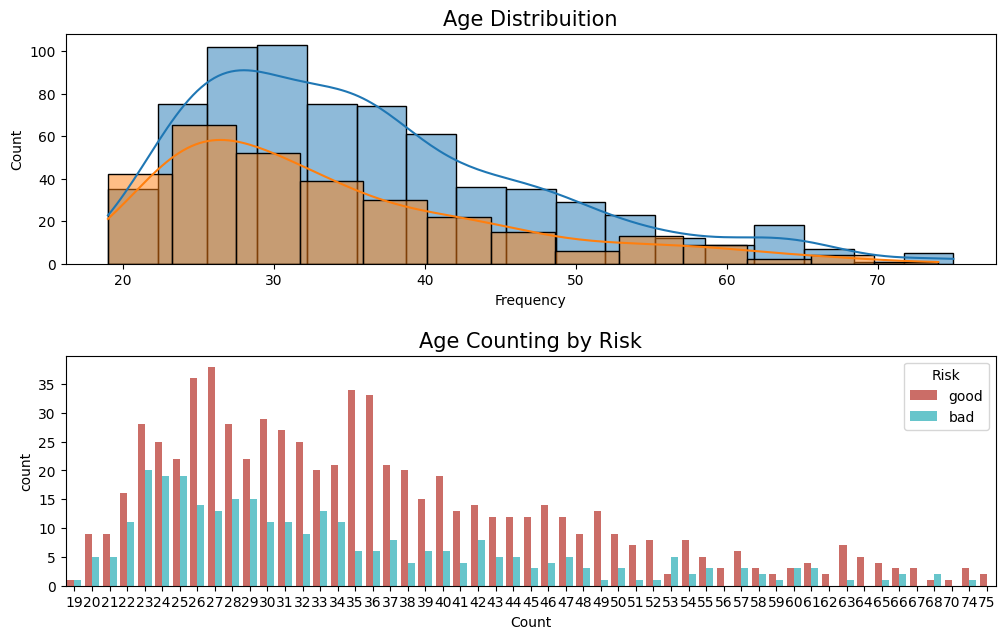

In [16]:
df_good = df[df["Risk"] == 'good']
df_bad = df[df["Risk"] == 'bad']

fig, ax = plt.subplots(nrows=2, figsize=(12,8))
plt.subplots_adjust(hspace = 0.4, top = 0.8)

g1 = sns.histplot(df_good["Age"], kde = True, ax=ax[0])
g1 = sns.histplot(df_bad["Age"], kde = True, ax = ax[0])
g1.set_title("Age Distribuition", fontsize=15)
g1.set_xlabel("Age")
g1.set_xlabel("Frequency")

g2 = sns.countplot(x="Age",data=df,
              palette="hls", ax=ax[1],
              hue = "Risk")
g2.set_title("Age Counting by Risk", fontsize=15)
g2.set_xlabel("Age")
g2.set_xlabel("Count")
plt.show()

In [17]:
#Age Disstribution along with categorizing
interval = (18, 25, 35, 60, 120)

cats = ['Student', 'Young', 'Adult', 'Senior']
df["Age_cat"] = pd.cut(df.Age, interval, labels=cats)


df_good = df[df["Risk"] == 'good']
df_bad = df[df["Risk"] == 'bad']

In [18]:
trace0 = go.Box(
    y=df_good["Credit amount"],
    x=df_good["Age_cat"],
    name='Good credit',
    marker=dict(
        color='green'
    )
)

trace1 = go.Box(
    y=df_bad['Credit amount'],
    x=df_bad['Age_cat'],
    name='Bad credit',
    marker=dict(
        color='sky blue'
    )
)

data = [trace0, trace1]

layout = go.Layout(
    yaxis=dict(
        title='Credit Amount (US Dollar)',
        zeroline=False
    ),
    xaxis=dict(
           title='Age Categorical'
    ),
    boxmode='group'
)
fig = go.Figure(data=data, layout=layout)

fig.show(renderer = "colab")


In [19]:
#Housing distribution with risk
#First Plot
trace0 = go.Bar(
    x = df[df["Risk"]== 'good']["Housing"].value_counts().index.values,
    y = df[df["Risk"]== 'good']["Housing"].value_counts().values,
    name='Good credit'
)

#Second plot
trace1 = go.Bar(
    x = df[df["Risk"]== 'bad']["Housing"].value_counts().index.values,
    y = df[df["Risk"]== 'bad']["Housing"].value_counts().values,
    name="Bad Credit"
)

data = [trace0, trace1]

layout = go.Layout(
    title='Housing Distribuition'
)


fig = go.Figure(data=data, layout=layout)
fig.show(renderer = "colab")


In [20]:
#Job Distribution
#First plot
trace0 = go.Bar(
                x = df[df["Risk"]== 'good']["Job"].value_counts().index.values,
                y = df[df["Risk"]== 'good']["Job"].value_counts().values,
                name='Good credit',
                marker=dict(
                color='tomato'
                    )
                )

#Second plot
trace1 = go.Bar(
                x = df[df["Risk"]== 'bad']["Job"].value_counts().index.values,
                y = df[df["Risk"]== 'bad']["Job"].value_counts().values,
                name="Bad Credit",
                marker=dict(
                color='teal'
                    )
                )

data = [trace0, trace1]
layout = go.Layout(title='Job Distribuitio')


fig = go.Figure(data=data, layout=layout)
fig.show(renderer = "colab")

In [21]:
trace0 = go.Box(
    x=df_good["Job"],
    y=df_good["Credit amount"],
    name='Good credit'
)

trace1 = go.Box(
    x=df_bad['Job'],
    y=df_bad['Credit amount'],
    name='Bad credit'
)

data = [trace0, trace1]

layout = go.Layout(
    yaxis=dict(
        title='Credit Amount distribuition by Job'
    ),
    boxmode='group'
)
fig = go.Figure(data=data, layout=layout)

fig.show(renderer = "colab")
""" The box plot displays the distribution of 'Credit amount' for different 'Job' categories,
llowing you to compare the distributions between 'Good credit' and 'Bad credit' groups
"""



" The box plot displays the distribution of 'Credit amount' for different 'Job' categories,\nllowing you to compare the distributions between 'Good credit' and 'Bad credit' groups\n"

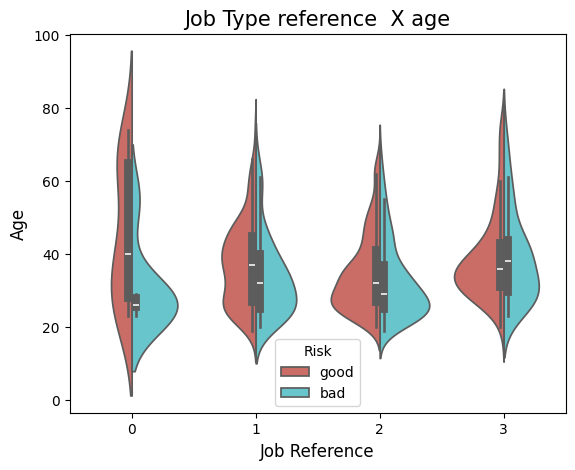

In [22]:

g2 = sns.violinplot(x="Job", y="Age", data=df,
               hue="Risk", split=True, palette="hls")
g2.set_title("Job Type reference  X age", fontsize=15)
g2.set_xlabel("Job Reference", fontsize=12)
g2.set_ylabel("Age", fontsize=12)

plt.subplots_adjust(hspace = 0.4,top = 0.9)

plt.show()

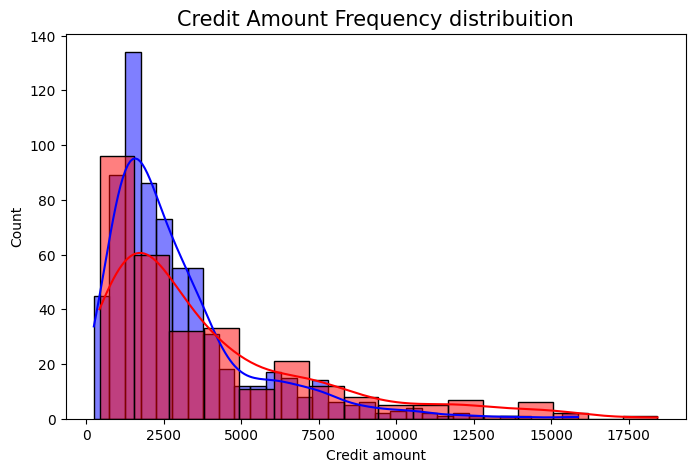

In [23]:
#Ploting the good and bad dataframes in distplot
plt.figure(figsize = (8,5))

g= sns.histplot(df_good['Credit amount'], color='b', kde = True)
g = sns.histplot(df_bad["Credit amount"], color='r', kde = True)
g.set_title("Credit Amount Frequency distribuition", fontsize=15)
plt.show()

In [24]:
# Histogram for credit amount by risk
x1 = np.log(df_good['Credit amount'])
x2 = np.log(df_bad["Credit amount"])

# Group data together
hist_data = [x1, x2]

group_labels = ['Good Credit', 'Bad Credit']
colors = ['rgb(0, 0, 100)', 'rgb(0, 200, 200)']

# Create distplot with custom bin_size
fig = ff.create_distplot(hist_data, group_labels, bin_size=.1, colors=colors)

# Plot!
fig.show(renderer = "colab")


In [25]:
count_good = go.Bar(
    x = df_good["Saving accounts"].value_counts().index.values,
    y = df_good["Saving accounts"].value_counts().values,
    name='Good credit'
)
count_bad = go.Bar(
    x = df_bad["Saving accounts"].value_counts().index.values,
    y = df_bad["Saving accounts"].value_counts().values,
    name='Bad credit'
)


box_1 = go.Box(
    x=df_good["Saving accounts"],
    y=df_good["Credit amount"],
    name='Good credit'
)
box_2 = go.Box(
    x=df_bad["Saving accounts"],
    y=df_bad["Credit amount"],
    name='Bad credit'
)

scat_1 = go.Box(
    x=df_good["Saving accounts"],
    y=df_good["Age"],
    name='Good credit'
)
scat_2 = go.Box(
    x=df_bad["Saving accounts"],
    y=df_bad["Age"],
    name='Bad credit'
)

data = [scat_1, scat_2, box_1, box_2, count_good, count_bad]

fig = tls.make_subplots(rows=2, cols=2, specs=[[{}, {}], [{'colspan': 2}, None]],
                          subplot_titles=('Count Saving Accounts','Credit Amount by Savings Acc',
                                          'Age by Saving accounts'))

fig.append_trace(count_good, 1, 1)
fig.append_trace(count_bad, 1, 1)

fig.append_trace(box_2, 1, 2)
fig.append_trace(box_1, 1, 2)

fig.append_trace(scat_1, 2, 1)
fig.append_trace(scat_2, 2, 1)



fig['layout'].update(height=700, width=800, title='Saving Accounts Exploration', boxmode='group')

fig.show(renderer = "colab")

/usr/local/lib/python3.10/dist-packages/plotly/tools.py:455: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



Description of Distribuition Saving accounts by Risk:  
Risk             bad  good
Saving accounts           
little           217   386
moderate          34    69
quite rich        11    52
rich               6    42


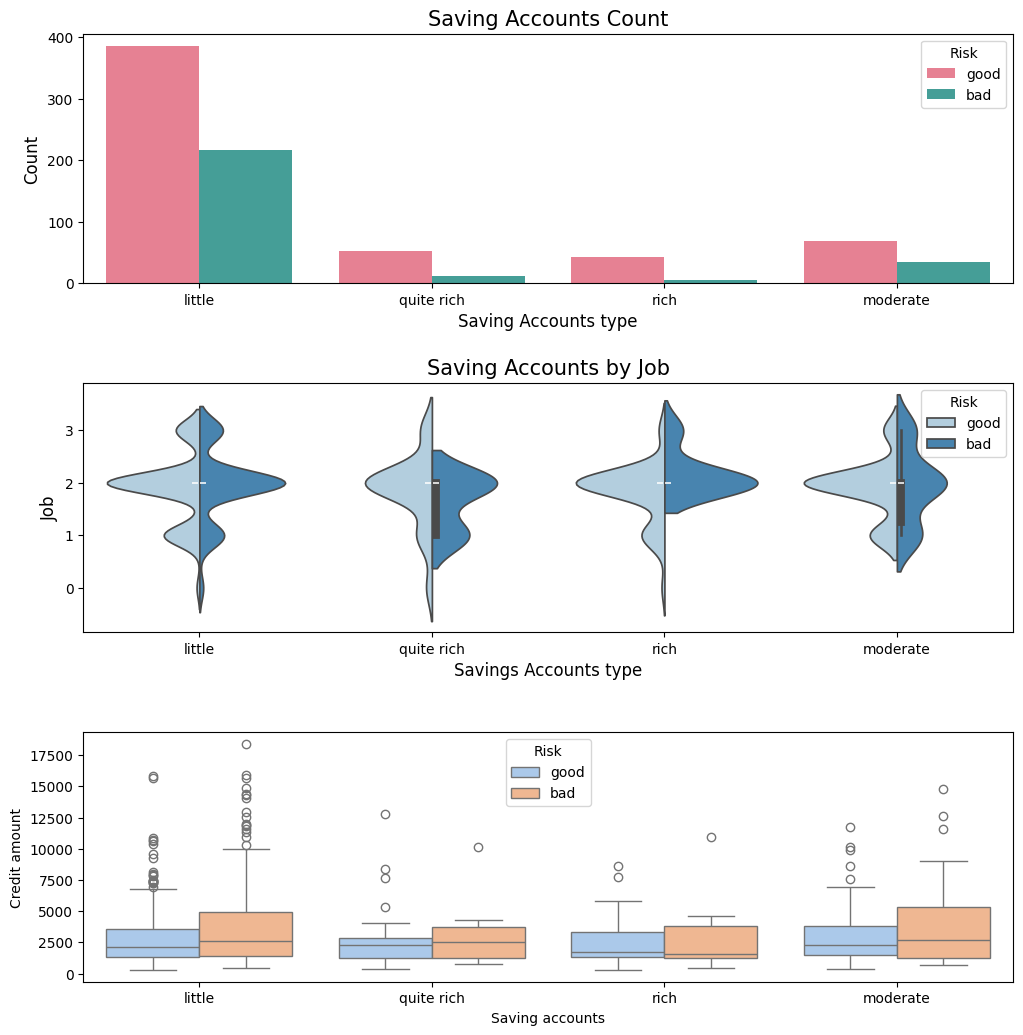

In [26]:
print("Description of Distribuition Saving accounts by Risk:  ")
print(pd.crosstab(df["Saving accounts"],df.Risk))

fig, ax = plt.subplots(3,1, figsize=(12,12))
g = sns.countplot(x="Saving accounts", data=df, palette="husl",
              ax=ax[0],hue="Risk")
g.set_title("Saving Accounts Count", fontsize=15)
g.set_xlabel("Saving Accounts type", fontsize=12)
g.set_ylabel("Count", fontsize=12)

g1 = sns.violinplot(x="Saving accounts", y="Job", data=df, palette="Blues",
               hue = "Risk", ax=ax[1],split=True)
g1.set_title("Saving Accounts by Job", fontsize=15)
g1.set_xlabel("Savings Accounts type", fontsize=12)
g1.set_ylabel("Job", fontsize=12)

g = sns.boxplot(x="Saving accounts", y="Credit amount", data=df, ax=ax[2],
            hue = "Risk",palette="pastel")
g2.set_title("Saving Accounts by Credit Amount", fontsize=15)
g2.set_xlabel("Savings Accounts type", fontsize=12)
g2.set_ylabel("Credit Amount(US)", fontsize=12)

plt.subplots_adjust(hspace = 0.4,top = 0.9)

plt.show()

Values describe: 
Risk                 bad  good
Purpose                       
business              34    63
car                  106   231
domestic appliances    4     8
education             23    36
furniture/equipment   58   123
radio/TV              62   218
repairs                8    14
vacation/others        5     7


<ipython-input-27-aaff6e79be52>:9: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

<ipython-input-27-aaff6e79be52>:17: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



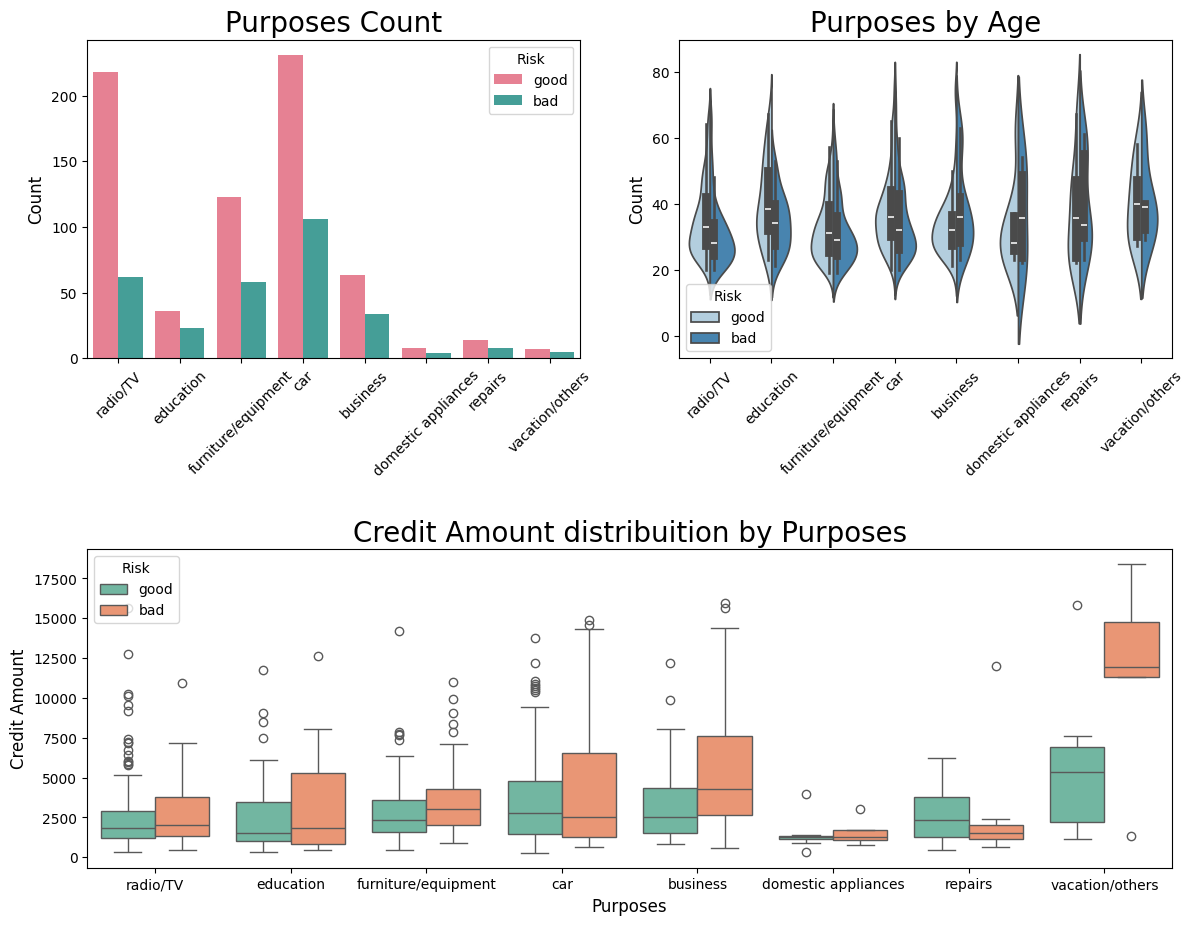

In [27]:
print("Values describe: ")
print(pd.crosstab(df.Purpose, df.Risk))

plt.figure(figsize = (14,12))

plt.subplot(221)
g = sns.countplot(x="Purpose", data=df,
              palette="husl", hue = "Risk")
g.set_xticklabels(g.get_xticklabels(),rotation=45)
g.set_xlabel("", fontsize=12)
g.set_ylabel("Count", fontsize=12)
g.set_title("Purposes Count", fontsize=20)

plt.subplot(222)
g1 = sns.violinplot(x="Purpose", y="Age", data=df,
                    palette="Blues", hue = "Risk",split=True)
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
g1.set_xlabel("", fontsize=12)
g1.set_ylabel("Count", fontsize=12)
g1.set_title("Purposes by Age", fontsize=20)

plt.subplot(212)
g2 = sns.boxplot(x="Purpose", y="Credit amount", data=df,
               palette="Set2", hue = "Risk")
g2.set_xlabel("Purposes", fontsize=12)
g2.set_ylabel("Credit Amount", fontsize=12)
g2.set_title("Credit Amount distribuition by Purposes", fontsize=20)

plt.subplots_adjust(hspace = 0.6, top = 0.8)

plt.show()

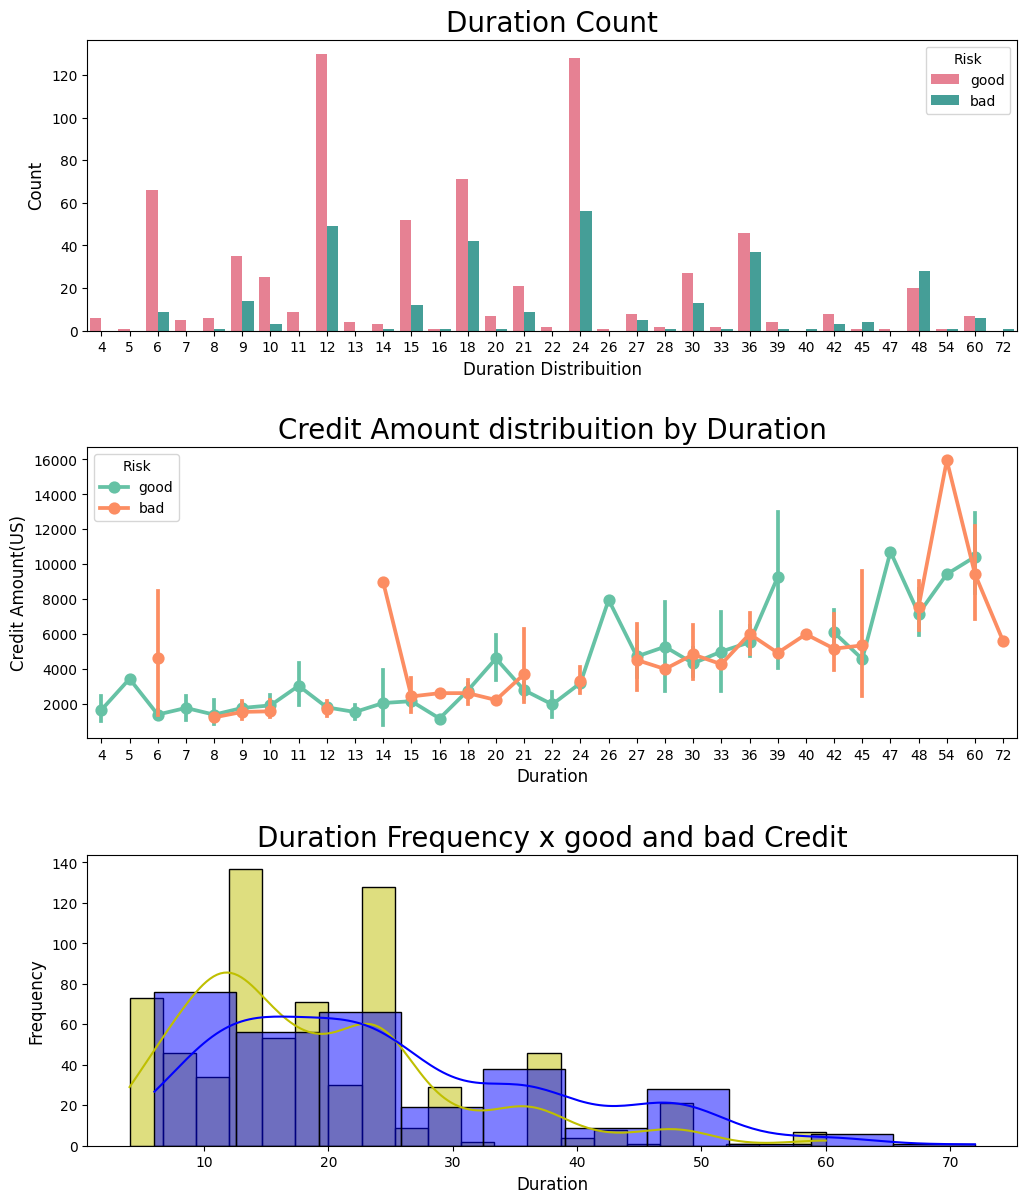

'\nInteresting, we can see that the highest duration have the high amounts.\nThe highest density is between [12 ~ 18 ~ 24] months\nIt all make sense.\n'

In [28]:
"""
Duration of the credits distribuition and density:¶
As seen, the 12th, 18th and 20th months are the time periods with the highest distribution.
"""

plt.figure(figsize = (12,14))

g= plt.subplot(311)
g = sns.countplot(x="Duration", data=df,
              palette="husl",  hue = "Risk")
g.set_xlabel("Duration Distribuition", fontsize=12)
g.set_ylabel("Count", fontsize=12)
g.set_title("Duration Count", fontsize=20)

g1 = plt.subplot(312)
g1 = sns.pointplot(x="Duration", y ="Credit amount",data=df,
                   hue="Risk", palette="Set2")
g1.set_xlabel("Duration", fontsize=12)
g1.set_ylabel("Credit Amount(US)", fontsize=12)
g1.set_title("Credit Amount distribuition by Duration", fontsize=20)

g2 = plt.subplot(313)
g2 = sns.histplot(df_good["Duration"], color='y', kde = True)
g2 = sns.histplot(df_bad["Duration"], color='b', kde = True)
g2.set_xlabel("Duration", fontsize=12)
g2.set_ylabel("Frequency", fontsize=12)
g2.set_title("Duration Frequency x good and bad Credit", fontsize=20)

plt.subplots_adjust(wspace = 0.4, hspace = 0.4,top = 0.9)

plt.show()
"\n"

"""
Interesting, we can see that the highest duration have the high amounts.
The highest density is between [12 ~ 18 ~ 24] months
It all make sense.
"""



In [29]:
#Checking account Balance
#First plot
trace0 = go.Bar(
    x = df[df["Risk"]== 'good']["Checking account"].value_counts().index.values,
    y = df[df["Risk"]== 'good']["Checking account"].value_counts().values,
    name='Good credit Distribuition'

)

#Second plot
trace1 = go.Bar(
    x = df[df["Risk"]== 'bad']["Checking account"].value_counts().index.values,
    y = df[df["Risk"]== 'bad']["Checking account"].value_counts().values,
    name="Bad Credit Distribuition"
)

data = [trace0, trace1]

layout = go.Layout(
    title='Checking accounts Distribuition',
    xaxis=dict(title='Checking accounts name'),
    yaxis=dict(title='Count'),
    barmode='group'

)


fig = go.Figure(data=data, layout=layout)
fig.show(renderer = 'colab')

In [30]:
df_good = df[df["Risk"] == 'good']
df_bad = df[df["Risk"] == 'bad']

trace0 = go.Box(
    y=df_good["Credit amount"],
    x=df_good["Checking account"],
    name='Good credit'
)

trace1 = go.Box(
    y=df_bad['Credit amount'],
    x=df_bad['Checking account'],
    name='Bad credit'

)

data = [trace0, trace1]

layout = go.Layout(
    yaxis=dict(
        title='Cheking distribuition'
    ),
    boxmode='group'
)
fig = go.Figure(data=data, layout=layout)

fig.show(renderer = 'colab')

Total values of the most missing variable: 
Checking account
little      274
moderate    269
rich         63
Name: Checking account, dtype: int64


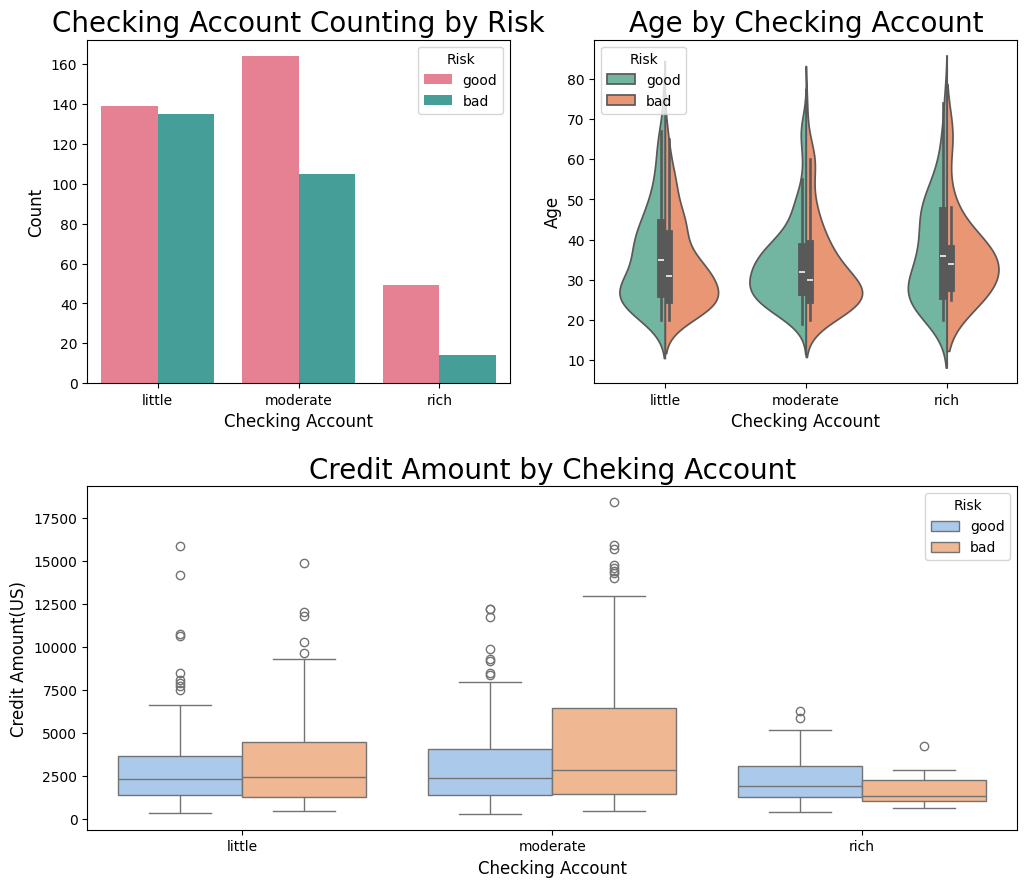

In [31]:
print("Total values of the most missing variable: ")
print(df.groupby("Checking account")["Checking account"].count())

plt.figure(figsize = (12,10))

g = plt.subplot(221)
g = sns.countplot(x="Checking account", data=df,
              palette="husl", hue="Risk")
g.set_xlabel("Checking Account", fontsize=12)
g.set_ylabel("Count", fontsize=12)
g.set_title("Checking Account Counting by Risk", fontsize=20)

g1 = plt.subplot(222)
g1 = sns.violinplot(x="Checking account", y="Age", data=df, palette="Set2", hue = "Risk",split=True)
g1.set_xlabel("Checking Account", fontsize=12)
g1.set_ylabel("Age", fontsize=12)
g1.set_title("Age by Checking Account", fontsize=20)

g2 = plt.subplot(212)
g2 = sns.boxplot(x="Checking account",y="Credit amount", data=df,hue='Risk',palette="pastel")
g2.set_xlabel("Checking Account", fontsize=12)
g2.set_ylabel("Credit Amount(US)", fontsize=12)
g2.set_title("Credit Amount by Cheking Account", fontsize=20)

plt.subplots_adjust(wspace = 0.2, hspace = 0.3, top = 0.9)

plt.show()
plt.show()

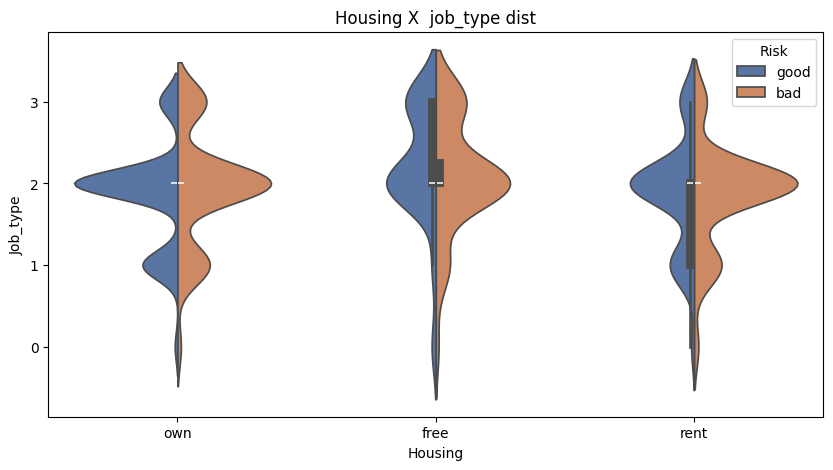

In [32]:
plt.figure(figsize=(10,5))
g = sns.violinplot(x='Housing',y ='Job',data = df,hue = 'Risk', palette = 'deep', split = True)
g.set_xlabel('Housing', fontsize = 10)
g.set_ylabel('Job_type', fontsize = 10)
g.set_title('Housing X  job_type dist', fontsize = 12)

plt.show()

In [33]:
from IPython.display import display

cross_sex_job = pd.crosstab(df['Sex'], df['Job'])
print('Job wise sex distribution:\n')
display(cross_sex_job.style.background_gradient(cmap='Blues'))

print("\n\n\nAccount status by gender\n\n", pd.crosstab(df["Checking account"],df.Sex))

Job wise sex distribution:



Job,0,1,2,3
Sex,,,,
female,12,64,197,37
male,10,136,433,111





Account status by gender

 Sex               female  male
Checking account              
little                88   186
moderate              86   183
rich                  20    43


In [34]:
pd.crosstab(df['Purpose'],df['Sex']).style.background_gradient(cmap = "viridis")

Sex,female,male
Purpose,,
business,19,78
car,94,243
domestic appliances,6,6
education,24,35
furniture/equipment,74,107
radio/TV,85,195
repairs,5,17
vacation/others,3,9


Filling missing values

In [35]:
df.isnull().sum()

,0
Age,0
Sex,0
Job,0
Housing,0
Saving accounts,183
Checking account,394
Credit amount,0
Duration,0
Purpose,0
Risk,0


In [36]:
mask = (df['Checking account'].isnull()) & (df['Saving accounts'].isnull())

# Filter the DataFrame using the mask
new_df = df[mask]

# Display the new DataFrame
new_df

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk,Age_cat
5,35,male,1,free,NaN,NaN,9055,36,education,good,Young
16,53,male,2,own,NaN,NaN,2424,24,radio/TV,good,Adult
24,26,male,2,own,NaN,NaN,2069,10,furniture/equipment,good,Young
33,57,male,1,rent,NaN,NaN,1264,12,business,good,Adult
53,31,male,2,own,NaN,NaN,3378,18,car,good,Young
...,...,...,...,...,...,...,...,...,...,...,...
947,38,male,3,own,NaN,NaN,2859,12,car,good,Adult
962,29,male,2,own,NaN,NaN,3556,15,car,good,Young
968,29,male,2,rent,NaN,NaN,7166,42,radio/TV,good,Young
990,37,male,1,own,NaN,NaN,3565,12,education,good,Adult


In [37]:
"""from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df_knn['saving_account_encoded'] = label_encoder.fit_transform(df['saving_account'].fillna('missing'))
df_knn['checking_account_encoded'] = label_encoder.fit_transform(df['checking_account'].fillna('missing'))
imputer = KNNImputer(n_neighbors=3)  # You can adjust n_neighbors
df[['saving_account_encoded', 'checking_account_encoded']] = imputer.fit_transform(
    df[['saving_account_encoded', 'checking_account_encoded']]
)

# Step 3: Convert the imputed numeric values back to the original categorical form
df['saving_account'] = label_encoder.inverse_transform(df['saving_account_encoded'].round().astype(int))
df['checking_account'] = label_encoder.inverse_transform(df['checking_account_encoded'].round().astype(int))
"""

"from sklearn.impute import KNNImputer\nfrom sklearn.preprocessing import LabelEncoder\nlabel_encoder = LabelEncoder()\ndf_knn['saving_account_encoded'] = label_encoder.fit_transform(df['saving_account'].fillna('missing'))\ndf_knn['checking_account_encoded'] = label_encoder.fit_transform(df['checking_account'].fillna('missing'))\nimputer = KNNImputer(n_neighbors=3)  # You can adjust n_neighbors\ndf[['saving_account_encoded', 'checking_account_encoded']] = imputer.fit_transform(\n    df[['saving_account_encoded', 'checking_account_encoded']]\n)\n\n# Step 3: Convert the imputed numeric values back to the original categorical form\ndf['saving_account'] = label_encoder.inverse_transform(df['saving_account_encoded'].round().astype(int))\ndf['checking_account'] = label_encoder.inverse_transform(df['checking_account_encoded'].round().astype(int))\n"

In [38]:
num_cols = [col for col in df.columns if df[col].dtypes != 'O']
print('Number of Numerical Variable: ', len(num_cols))

Number of Numerical Variable:  5


In [39]:
non_cat_col = ['Age', 'Credit amount', 'Duration']

Checking for outlier (using IQR)



In [40]:
def outlier_thresholds(dataframe, list_variables):
    thresholds = {}
    for variable in list_variables:
        quartile1 = dataframe[variable].quantile(0.25)
        quartile3 = dataframe[variable].quantile(0.75)
        interquantile_range = quartile3 - quartile1
        up_limit = quartile3 + 1.5 * interquantile_range
        low_limit = quartile1 - 1.5 * interquantile_range
        thresholds[variable] = (low_limit, up_limit)
    return thresholds


In [41]:
outlier_thresholds(df, non_cat_col)

{'Age': (4.5, 64.5),
 'Credit amount': (-2544.625, 7882.375),
 'Duration': (-6.0, 42.0)}

Age : 23


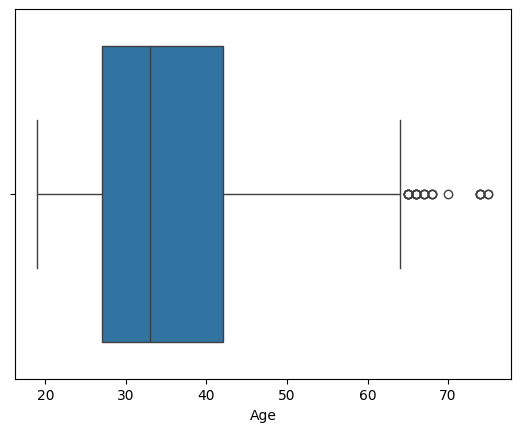

Credit amount : 72


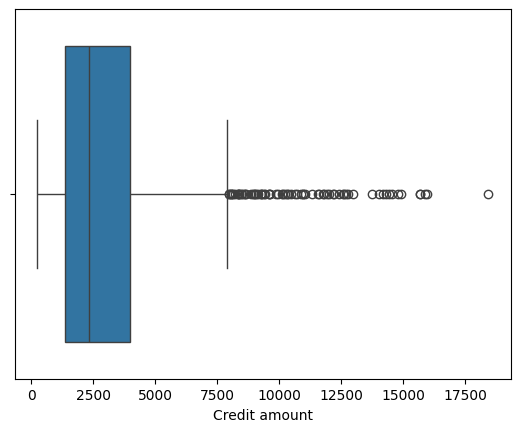

Duration : 70


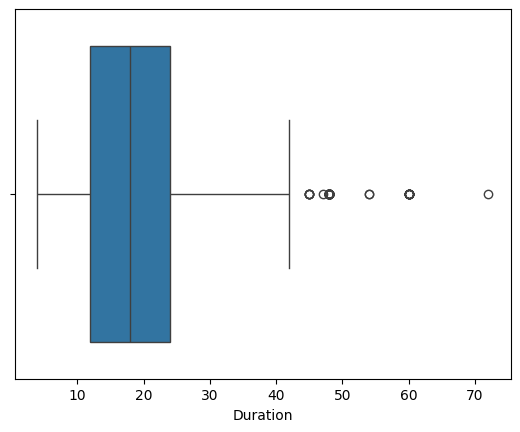

['Age', 'Credit amount', 'Duration']

In [42]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.25)
    quartile3 = dataframe[variable].quantile(0.75)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def has_outliers(dataframe, num_col_names, plot=True):
    variable_names = []
    for col_nam in num_col_names:
        if dataframe[col_nam].dtype.kind in 'bifc':  # Check if column is numeric
            low_limit, up_limit = outlier_thresholds(dataframe, col_nam)
            outlier_condition = (dataframe[col_nam] > up_limit) | (dataframe[col_nam] < low_limit)
            if outlier_condition.any():  # Check if there are any outliers
                number_of_outliers = dataframe[outlier_condition].shape[0]
                print(col_nam, ":", number_of_outliers)
                variable_names.append(col_nam)
                sns.boxplot(x=dataframe[col_nam])
                plt.show()
    return variable_names



has_outliers(df,non_cat_col)

In [43]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit


for col in non_cat_col:
    replace_with_thresholds(df, col)

has_outliers(df,non_cat_col)

<ipython-input-43-036a9465be0d>:3: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '4.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

<ipython-input-43-036a9465be0d>:3: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-2544.625' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



[]

In [44]:
has_outliers(df,non_cat_col)
# ensuring that all the outlier have been removed

[]

Installizing KNN process

In [45]:
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk,Age_cat
0,64.5,male,2,own,NaN,little,1169.0,6,radio/TV,good,Senior
1,22.0,female,2,own,little,moderate,5951.0,42,radio/TV,bad,Student
2,49.0,male,1,own,little,NaN,2096.0,12,education,good,Adult
3,45.0,male,2,free,little,little,7882.0,42,furniture/equipment,good,Adult
4,53.0,male,2,free,little,little,4870.0,24,car,bad,Adult


In [46]:
df_knn = df.copy()
df_knn.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk,Age_cat
0,64.5,male,2,own,NaN,little,1169.0,6,radio/TV,good,Senior
1,22.0,female,2,own,little,moderate,5951.0,42,radio/TV,bad,Student
2,49.0,male,1,own,little,NaN,2096.0,12,education,good,Adult
3,45.0,male,2,free,little,little,7882.0,42,furniture/equipment,good,Adult
4,53.0,male,2,free,little,little,4870.0,24,car,bad,Adult


In [47]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
# Initialize LabelEncoder
label_encoder = LabelEncoder()
encoder = OrdinalEncoder()

# Fit and transform the Category column
df_knn[['Saving accounts', 'Checking account']] = encoder.fit_transform(df_knn[['Saving accounts', 'Checking account']])
# we used ordinal encoder in order to avoide the missing values to get encoded
df_knn['Age_cat'] = label_encoder.fit_transform(df_knn['Age_cat'])
df_knn['Purpose'] = label_encoder.fit_transform(df_knn['Purpose'])
df_knn['Sex'] = label_encoder.fit_transform(df_knn['Sex'])
df_knn['Housing'] = label_encoder.fit_transform(df_knn['Housing'])
df_knn['Job'] = label_encoder.fit_transform(df_knn['Job'])
df_knn['Risk'] = label_encoder.fit_transform(df_knn['Risk'])
del df_knn['Age']

In [48]:
df_knn.head()

,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk,Age_cat
0,1,2,1,NaN,0.0,1169.0,6,5,1,1
1,0,2,1,0.0,1.0,5951.0,42,5,0,2
2,1,1,1,0.0,NaN,2096.0,12,3,1,0
3,1,2,0,0.0,0.0,7882.0,42,4,1,0
4,1,2,0,0.0,0.0,4870.0,24,1,0,0


In [49]:
df_filtered = df_knn.dropna(subset=['Saving accounts','Checking account'])

# Display the filtered DataFrame
df_filtered.shape
# df_filtered  containd only missing values in the 'Checking account' column and we dropped  the rows that contain missing values in 'Saving account'

(522, 10)

In [50]:
df_filtered.isnull().sum()

,0
Sex,0
Job,0
Housing,0
Saving accounts,0
Checking account,0
Credit amount,0
Duration,0
Purpose,0
Risk,0
Age_cat,0


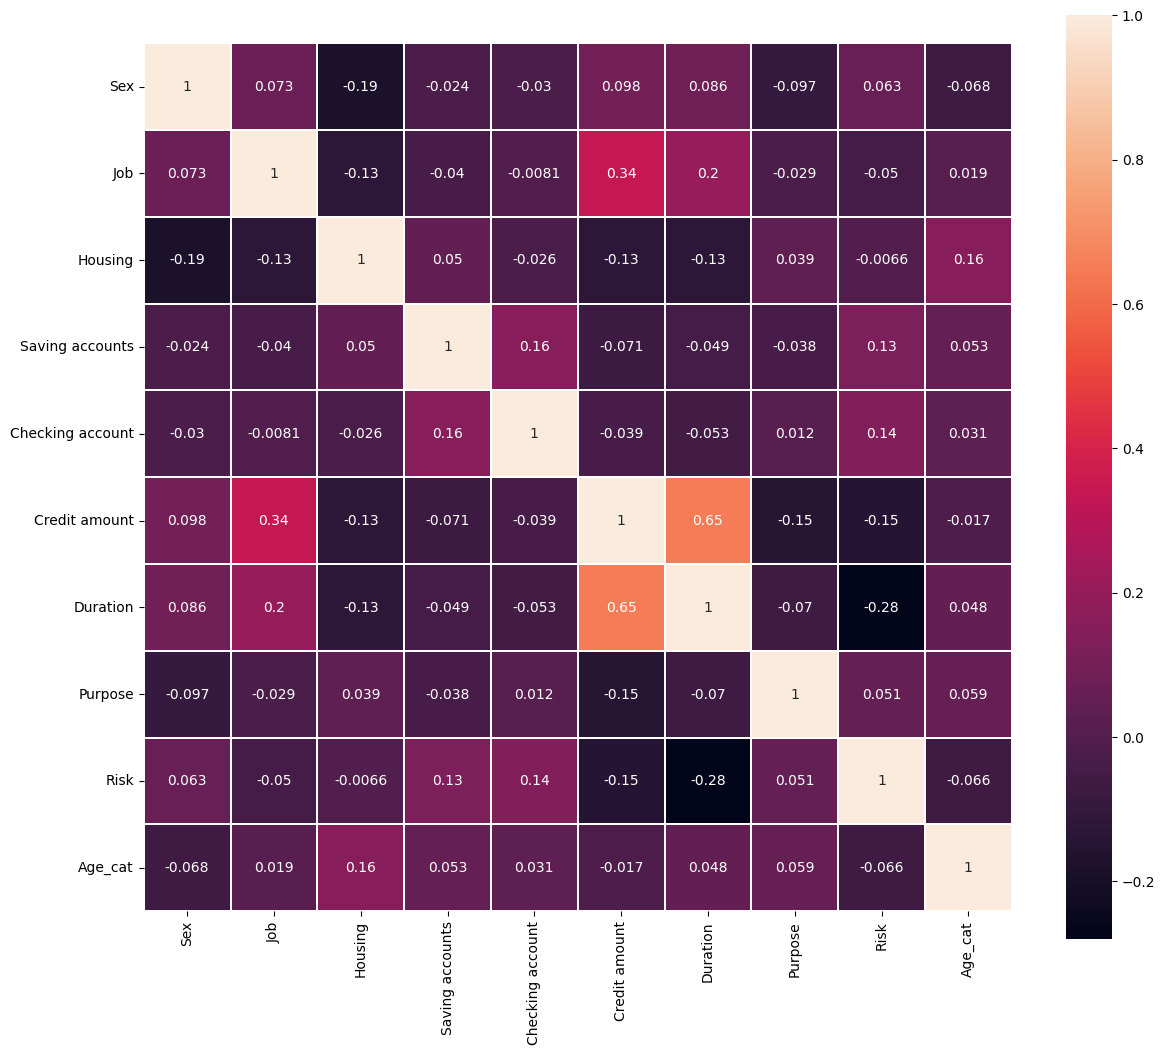

In [51]:
plt.figure(figsize=(14,12))
sns.heatmap(df_filtered.astype(float).corr(),linewidths=0.1,vmax=1.0,
            square=True,  linecolor='white', annot=True)
plt.show()

In [52]:
#splitting the dataset into X_train and Y_train and then find cross validation error
from sklearn.model_selection import train_test_split
#Creating the X and y variables
X = df_filtered.drop('Checking account', axis = 1).values
y = df_filtered["Checking account"].values

# Spliting X and y into train and test version
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)



now we use gridsearch to find the optimal value for k

In [53]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

param_grid = {'n_neighbors': range(1, 100)}
knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn, param_grid, cv=10, scoring='f1_weighted')
knn_cv.fit(X, y)

print(f"Best k: {knn_cv.best_params_}")
print(f"Best cross-validation: {knn_cv.best_score_}")

Best k: {'n_neighbors': 36}
Best cross-validation: 0.46631973890195777


In [54]:
df_knn.nunique()

,0
Sex,2
Job,4
Housing,3
Saving accounts,4
Checking account,3
Credit amount,850
Duration,27
Purpose,8
Risk,2
Age_cat,4


In [55]:
# Initialize the KNNImputer
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=36)

# Apply KNN imputation
df_imputed = imputer.fit_transform(df_knn)

# Convert the result back to DataFrame
df_imputed = pd.DataFrame(df_imputed, columns=df_knn.columns)

# Optionally, round the imputed values for categorical columns
df_imputed[['Saving accounts', 'Checking account']] = df_imputed[['Saving accounts', 'Checking account']].round()

print(df_imputed)

     Sex  Job  Housing  Saving accounts  Checking account  Credit amount  \
0    1.0  2.0      1.0              1.0               0.0         1169.0   
1    0.0  2.0      1.0              0.0               1.0         5951.0   
2    1.0  1.0      1.0              0.0               1.0         2096.0   
3    1.0  2.0      0.0              0.0               0.0         7882.0   
4    1.0  2.0      0.0              0.0               0.0         4870.0   
..   ...  ...      ...              ...               ...            ...   
995  0.0  1.0      1.0              0.0               0.0         1736.0   
996  1.0  3.0      1.0              0.0               0.0         3857.0   
997  1.0  2.0      1.0              0.0               1.0          804.0   
998  1.0  2.0      0.0              0.0               0.0         1845.0   
999  1.0  2.0      1.0              1.0               1.0         4576.0   

     Duration  Purpose  Risk  Age_cat  
0         6.0      5.0   1.0      1.0  
1      

In [56]:
df_imputed.nunique()

,0
Sex,2
Job,4
Housing,3
Saving accounts,4
Checking account,3
Credit amount,850
Duration,27
Purpose,8
Risk,2
Age_cat,4


Now what we will do is manually decode the encoded values to its original value and then use one hot encoding.

Sex: { 1:male , 0 : female} \\

Housing : { 0: free , 1:own, 2:rent} \\

Saving Accounts : { 0:little , 1:moderate , 2:quite rich, 3:rich   } \\

Checking account : { 0:little , 1:moderate , 2:rich } \\

Purpose : {0: bussiness, 1: car, 2: domestic appliances, 3: education, 4: furniture/equipment, 5: radio/TV, 6: repair, 7: vacation/others } \\

Risk: { 0:bad, 1: good} \\

Age_cat: {0:Adult, 1:Senior, 2:Student,3:Young} \\





**Now we reverse encode the variables and then one hot encode it :**

In [57]:
df_imputed['Sex'] = df_imputed['Sex'].map({0: 'female', 1: 'male'})
df_imputed['Housing'] = df_imputed['Housing'].map({0: 'free', 1: 'own', 2: 'rent'})
df_imputed['Saving accounts'] = df_imputed['Saving accounts'].map({0: 'little', 1: 'moderate', 2: 'quite rich', 3: 'rich'})
df_imputed['Checking account'] = df_imputed['Checking account'].map({0: 'little', 1: 'moderate', 2: 'rich'})
df_imputed['Purpose'] = df_imputed['Purpose'].map({0: 'bussiness',1: 'car', 2: 'domestic appliances', 3: 'education', 4: 'furniture/equipment', 5: 'radio/TV', 6: 'repair', 7: 'vacation/others'})
df_imputed['Risk'] = df_imputed['Risk'].map({0: 'bad', 1: 'good'})
df_imputed['Age_cat'] = df_imputed['Age_cat'].map({0: 'Adult', 1: 'Senior', 2: 'Student',3: 'Young'})
df_imputed.head()


,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk,Age_cat
0,male,2.0,own,moderate,little,1169.0,6.0,radio/TV,good,Senior
1,female,2.0,own,little,moderate,5951.0,42.0,radio/TV,bad,Student
2,male,1.0,own,little,moderate,2096.0,12.0,education,good,Adult
3,male,2.0,free,little,little,7882.0,42.0,furniture/equipment,good,Adult
4,male,2.0,free,little,little,4870.0,24.0,car,bad,Adult


In [58]:
"""from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

# Assuming X_train and y_train are your features and target variable
k_values = range(1, 31)
cv_scores = []

# Perform 5-fold cross-validation for each k
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

# Optimal k is the one with the highest cross-validation score
optimal_k = k_values[np.argmax(cv_scores)]
print(f"The optimal number of neighbors is {optimal_k}")"""


'from sklearn.model_selection import cross_val_score\nfrom sklearn.neighbors import KNeighborsClassifier\n\n# Assuming X_train and y_train are your features and target variable\nk_values = range(1, 31)\ncv_scores = []\n\n# Perform 5-fold cross-validation for each k\nfor k in k_values:\n    knn = KNeighborsClassifier(n_neighbors=k)\n    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring=\'accuracy\')\n    cv_scores.append(scores.mean())\n\n# Optimal k is the one with the highest cross-validation score\noptimal_k = k_values[np.argmax(cv_scores)]\nprint(f"The optimal number of neighbors is {optimal_k}")'

One-Hot Encoding( 2 ways either use pandas or sklearn)

In [59]:
cat_columns = df_imputed.select_dtypes(include=['object']).columns.tolist()

"""or you can first manually checck the data type for all the columns and the make
a column list and store it in a variable_type"""

cat_columns


['Sex',
 'Housing',
 'Saving accounts',
 'Checking account',
 'Purpose',
 'Risk',
 'Age_cat']

In [60]:
cat_columns.append('Job')
cat_columns

['Sex',
 'Housing',
 'Saving accounts',
 'Checking account',
 'Purpose',
 'Risk',
 'Age_cat',
 'Job']

In [61]:
df_imputed_1 = pd.get_dummies(df_imputed, columns=cat_columns, drop_first=True)
df_imputed_2 = pd.get_dummies(df_imputed, columns=cat_columns)
df_imputed_1.info()
df_imputed_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Credit amount                1000 non-null   float64
 1   Duration                     1000 non-null   float64
 2   Sex_male                     1000 non-null   bool   
 3   Housing_own                  1000 non-null   bool   
 4   Housing_rent                 1000 non-null   bool   
 5   Saving accounts_moderate     1000 non-null   bool   
 6   Saving accounts_quite rich   1000 non-null   bool   
 7   Saving accounts_rich         1000 non-null   bool   
 8   Checking account_moderate    1000 non-null   bool   
 9   Checking account_rich        1000 non-null   bool   
 10  Purpose_car                  1000 non-null   bool   
 11  Purpose_domestic appliances  1000 non-null   bool   
 12  Purpose_education            1000 non-null   bool   
 13  Purpose_furniture/e

In [62]:
df_imputed_1['Risk_bad'] = df_imputed_2['Risk_bad']
df_imputed_1.drop('Risk_good', axis=1, inplace=True)

In [63]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()

# Assuming 'Credit amount' and 'Duration' are the columns to be standardized
df_imputed_1[['Credit amount', 'Duration']] = scaler.fit_transform(df_imputed_1[['Credit amount', 'Duration']])


In [64]:
df_imputed_1.head()

,Credit amount,Duration,Sex_male,Housing_own,Housing_rent,Saving accounts_moderate,Saving accounts_quite rich,Saving accounts_rich,Checking account_moderate,Checking account_rich,...,Purpose_radio/TV,Purpose_repair,Purpose_vacation/others,Age_cat_Senior,Age_cat_Student,Age_cat_Young,Job_1.0,Job_2.0,Job_3.0,Risk_bad
0,-0.441354,-1.0,True,True,False,True,False,False,False,False,...,True,False,False,True,False,False,False,True,False,False
1,1.393114,2.0,False,True,False,False,False,False,True,False,...,True,False,False,False,True,False,False,True,False,True
2,-0.085739,-0.5,True,True,False,False,False,False,True,False,...,False,False,False,False,False,False,True,False,False,False
3,2.133883,2.0,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
4,0.978421,0.5,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,True


Modelling

startig with splitting the data into X and y

In [65]:
#Creating the X and y variables
X_id = df_imputed_1.drop('Risk_bad',axis=1).values
y_d = df_imputed_1["Risk_bad"].values

# Spliting X and y into train and test version
X_train, X_test, y_train, y_test = train_test_split(X_id, y_d, test_size = 0.25, random_state=42)

In [66]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(750, 23)
(750,)
(250, 23)
(250,)


In [67]:
rf =  RandomForestClassifier()
xgb = XGBClassifier()
GNB = GaussianNB()

Random forest model

In [68]:
rf.fit (X_train, y_train)
y_pred = rf.predict(X_test)
accuracy_score(y_test, y_pred)

0.724

In [69]:
print(confusion_matrix(y_test, y_pred))

[[159  19]
 [ 50  22]]


Hyperparameter tuning

In [70]:
param_grid = {
    'n_estimators': [20,60,100,120], #no of decidion trees to used
    'max_depth': [None, 10, 20, 30], #depth of the decision trees
    'min_samples_split': [2, 5, 10], #
    'max_features': [0.2, 0.6, 1] #no of columns that every decision tree would get: k<n(max number of features)
}

# Initialize the Random Forest classifier
rf = RandomForestClassifier(random_state=42)

# Use GridSearchCV to find the best parameters
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=10, scoring='accuracy', n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Display the best parameters and the best score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_}")

Fitting 10 folds for each of 144 candidates, totalling 1440 fits
Best parameters: {'max_depth': None, 'max_features': 0.6, 'min_samples_split': 10, 'n_estimators': 120}
Best cross-validation accuracy: 0.7333333333333334


In [71]:
rf = RandomForestClassifier(max_depth=None, max_features= 0.6, n_estimators=120, min_samples_split = 10)

#trainning with the best params
rf.fit(X_train, y_train)

RandomForestClassifier(max_features=0.6, min_samples_split=10, n_estimators=120)

In [72]:
from sklearn.metrics import classification_report
y_pred = rf.predict(X_test)
print(accuracy_score(y_test,y_pred))
print("\n")
print(confusion_matrix(y_test, y_pred))
print("\n")
print(classification_report(y_test, y_pred))

0.728


[[159  19]
 [ 49  23]]


              precision    recall  f1-score   support

       False       0.76      0.89      0.82       178
        True       0.55      0.32      0.40        72

    accuracy                           0.73       250
   macro avg       0.66      0.61      0.61       250
weighted avg       0.70      0.73      0.70       250



XG Boost model

In [75]:
xgb = XGBClassifier( learning_rate = 0.01, max_deapth = 5, min_samples_split = 0.1, n_estimators = 100, subsample = 1)
xgb.fit(X_train, y_train)
model_xgb =xgb.fit (X_train, y_train)
y_pred = model_xgb.predict(X_test)
accuracy_score(y_test, y_pred)
print(accuracy_score(y_test,y_pred))
print("\n")
print(confusion_matrix(y_test, y_pred))
print("\n")
print(classification_report(y_test, y_pred))

0.744


[[173   5]
 [ 59  13]]


              precision    recall  f1-score   support

       False       0.75      0.97      0.84       178
        True       0.72      0.18      0.29        72

    accuracy                           0.74       250
   macro avg       0.73      0.58      0.57       250
weighted avg       0.74      0.74      0.68       250



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning:

[13:22:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "max_deapth", "min_samples_split" } are not used.




Noraml Bayesian

In [77]:
model_GNB = GNB.fit (X_train, y_train)
y_pred = model_GNB.predict(X_test)
print(accuracy_score(y_test,y_pred))
print("\n")
print(confusion_matrix(y_test, y_pred))
print("\n")
print(classification_report(y_test, y_pred))

0.628


[[125  53]
 [ 40  32]]


              precision    recall  f1-score   support

       False       0.76      0.70      0.73       178
        True       0.38      0.44      0.41        72

    accuracy                           0.63       250
   macro avg       0.57      0.57      0.57       250
weighted avg       0.65      0.63      0.64       250



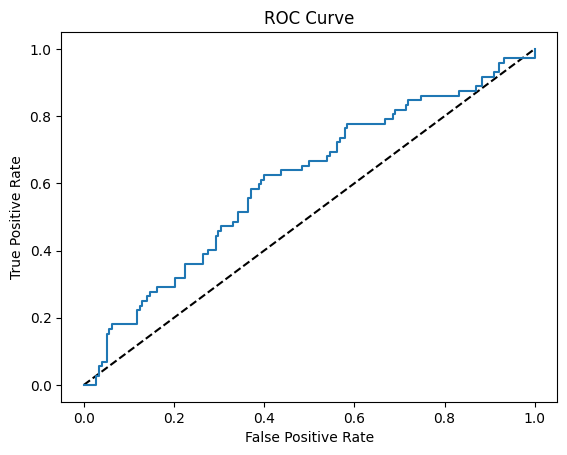

In [78]:
from sklearn.utils import resample
from sklearn.metrics import roc_curve
y_pred_prob = model_GNB.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve for normal bayesian
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

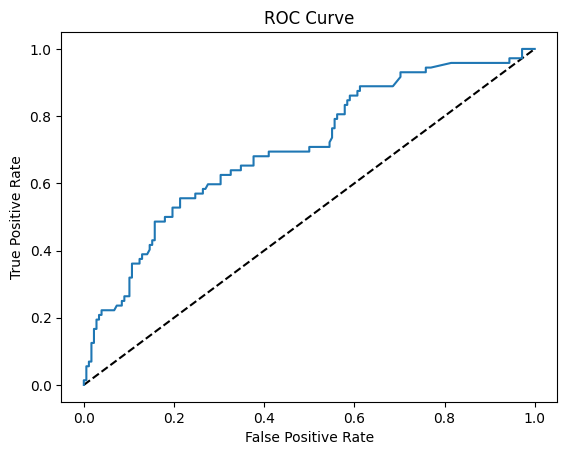

In [79]:
y_pred_prob = model_xgb.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve for normal bayesian
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()